## Importing Necessary Modules

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from typing import Any

## Adding Paths

In [2]:
import os
from pathlib import Path

image_path = Path("../../data/")
print(os.listdir(image_path))

['1. Original Images', '2. All Segmentation Groundtruths', 'CC-BY-4.0.txt', 'LICENSE.txt']


In [3]:
X_train_dir = Path(image_path / "1. Original Images/a. Training Set")
y_train_dir = Path(image_path / "2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages")
X_test_dir = Path(image_path / "1. Original Images/b. Testing Set")
y_test_dir = Path(image_path / "2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages")

print(os.listdir(X_train_dir)[:5])
print(os.listdir(y_train_dir)[:5])
print(os.listdir(X_test_dir)[:5])
print(os.listdir(y_test_dir)[:5])

['IDRiD_01.jpg', 'IDRiD_02.jpg', 'IDRiD_03.jpg', 'IDRiD_04.jpg', 'IDRiD_05.jpg']
['IDRiD_01_HE.tif', 'IDRiD_02_HE.tif', 'IDRiD_03_HE.tif', 'IDRiD_04_HE.tif', 'IDRiD_05_HE.tif']
['IDRiD_55.jpg', 'IDRiD_56.jpg', 'IDRiD_57.jpg', 'IDRiD_58.jpg', 'IDRiD_59.jpg']
['IDRiD_55_HE.tif', 'IDRiD_56_HE.tif', 'IDRiD_57_HE.tif', 'IDRiD_58_HE.tif', 'IDRiD_59_HE.tif']


### Training Image

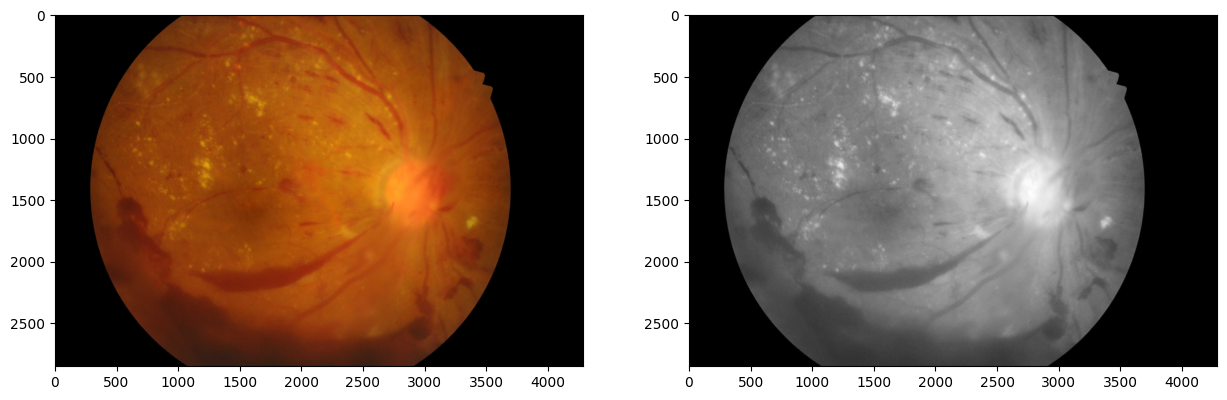

In [4]:
from PIL import Image, ImageOps

img = Image.open(Path(X_train_dir / os.listdir(X_train_dir)[16]))
img_grayed = ImageOps.grayscale(img)

numpy_img = np.asarray(img)
numpy_img_grayed = np.asarray(img_grayed)

plt.rcParams['figure.figsize'] = [15, 15]
fig, axis = plt.subplots(1, 2)
axis[0].imshow(numpy_img)
axis[1].imshow(numpy_img_grayed, cmap="gray")

### Training Image Mask

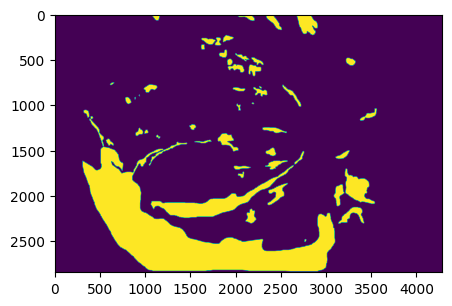

In [5]:
img_mask = Image.open(Path(y_train_dir  / "IDRiD_17_HE.tif"))

numpy_img = np.asarray(img_mask)

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(numpy_img)

## Loading Dataset

In [6]:
img_height = 128
img_width = 128

In [8]:
def preprocess_input(x):
    return x / 255

# --------------------------------------------X train dataset--------------------------------------------------#
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    X_train_dir,
    labels=None,
    batch_size=1,
    color_mode='rgb',
    image_size=(img_height, img_width),
    shuffle=False,
    interpolation='bilinear',)
X_train = X_train.map(lambda x: (preprocess_input(x)))

# --------------------------------------------y train dataset--------------------------------------------------#
y_train_list = []
for images in os.listdir(y_train_dir):
    img = Image.open(Path(y_train_dir / images)).resize((img_width, img_height), resample=Image.BILINEAR)
    img_arr = np.expand_dims(np.array(img)/255, axis=-1)
    y_train_list.append(img_arr)
#y_train_list = np.expand_dims(y_train_list, axis=1)
y_train = tf.data.Dataset.from_tensor_slices(y_train_list)

# --------------------------------------------X test dataset---------------------------------------------------#
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    X_test_dir,
    labels=None,
    batch_size=1,
    color_mode='rgb',
    image_size=(img_height, img_width),
    shuffle=False,
    interpolation='bilinear',)
X_test = X_test.map(lambda x: (preprocess_input(x)))

# --------------------------------------------y test dataset---------------------------------------------------#
y_test_list = []
for images in os.listdir(y_test_dir):
    img = Image.open(Path(y_test_dir / images)).resize((img_width, img_height), resample=Image.BILINEAR)
    img_arr = np.expand_dims(np.array(img)/255, axis=-1)
    y_test_list.append(img_arr)
#y_test_list = np.expand_dims(y_train_list, axis=1)
y_test = tf.data.Dataset.from_tensor_slices(y_test_list)

train_dataset = tf.data.Dataset.zip((X_train, y_train))


Found 54 files belonging to 1 classes.
Found 27 files belonging to 1 classes.


(1, 128, 128, 3) (128, 128, 1)


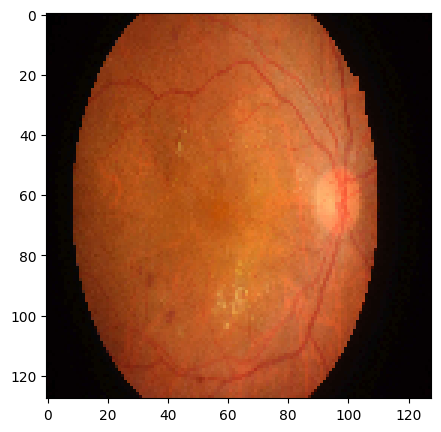

In [9]:
inp = train_dataset.take(1)
for i, j in inp:
    print(i.shape, j.shape)
    plt.imshow(i[0, :, :, :])

## U-Net Model

In [11]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Input, Concatenate, Dropout, BatchNormalization, Activation


def conv_block(inp, filters) -> Any:
    conv = Conv2D(filters, 3, padding='same')(inp)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filters, 3, padding='same')(inp)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv


def encoder_layer(inp: Any, filters:int) -> [Any, Any]:
    enc = conv_block(inp, filters)
    enc_pool = MaxPool2D((2, 2))(enc)
    return enc, enc_pool


def decoder_layer(inp:Any, skip_connections:Any, filters:int) -> Any:
    dec = Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(inp)
    dec = Concatenate()([dec, skip_connections])
    dec = conv_block(dec, filters)
    return dec

In [12]:
def U_Net(input_shape):
    inputs = Input(input_shape)
    print("Inputs:", inputs)

    ds1, dp1 = encoder_layer(inputs, 64) # downsampling layer1 → → → → → → → → →  128 x 128 x 64
                                         #   ↓                                 ↓
    ds2, dp2 = encoder_layer(dp1, 128)   # downsampling layer2 → → → → → → →   ↓  
                                         #   ↓                             ↓   ↓
    ds3, dp3 = encoder_layer(dp2, 256)   # downsampling layer3 → → → → →   ↓   ↓ 
                                         #   ↓                         ↓   ↓   ↓
    ds4, dp4 = encoder_layer(dp3, 512)   # downsampling layer4 → → →   ↓   ↓   ↓
                                         #   ↓                     ↓   ↓   ↓   ↓
    bc = conv_block(dp4, 1024)           # bridge connect layer    ↓   ↓   ↓   ↓
                                         #   ↓                     ↓   ↓   ↓   ↓
    us1 = decoder_layer(bc, ds4, 512)    # upsampling layer1 ← ← ← ←   ↓   ↓   ↓
                                         #   ↓                         ↓   ↓   ↓
    us2 = decoder_layer(us1, ds3, 256)   # upsampling layer2 ← ← ← ← ← ←   ↓   ↓
                                         #   ↓                             ↓   ↓
    us3 = decoder_layer(us2, ds2, 128)   # upsampling layer3 ← ← ← ← ← ← ← ←   ↓    
                                         #   ↓                                 ↓
    us4 = decoder_layer(us3, ds1, 64)    # upsampling layer4 ← ← ← ← ← ← ← ← ← ←


    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(us4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [13]:
from helpers.helper import Metrics
from keras.optimizers import SGD, Adam

metrics = Metrics()
model = U_Net((img_height, img_width, 3))
model.compile(optimizer=Adam(learning_rate=1e-6), 
              loss=metrics.cohenkappa,
              metrics=metrics.iou)
model.summary()

Inputs: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo 

In [14]:
batch_size = 16
model.fit(train_dataset, batch_size=batch_size, epochs=15)

Epoch 1/15


53/53 [==============================] - 7s 43ms/step - loss: 0.0105 - iou: 0.0054
Epoch 2/15
53/53 [==============================] - 2s 44ms/step - loss: 0.0105 - iou: 0.0054
Epoch 3/15
53/53 [==============================] - 2s 45ms/step - loss: 0.0104 - iou: 0.0053
Epoch 4/15
53/53 [==============================] - 2s 45ms/step - loss: 0.0103 - iou: 0.0053
Epoch 5/15
53/53 [==============================] - 2s 44ms/step - loss: 0.0101 - iou: 0.0052
Epoch 6/15
53/53 [==============================] - 2s 44ms/step - loss: 0.0100 - iou: 0.0052
Epoch 7/15
53/53 [==============================] - 2s 44ms/step - loss: 0.0099 - iou: 0.0051
Epoch 8/15
53/53 [==============================] - 2s 44ms/step - loss: 0.0098 - iou: 0.0050
Epoch 9/15
53/53 [==============================] - 2s 45ms/step - loss: 0.0097 - iou: 0.0050
Epoch 10/15
53/53 [==============================] - 2s 45ms/step - loss: 0.0095 - iou: 0.0049
Epoch 11/15
53/53 [==============================] - 2s 45ms/step - lo

In [15]:
img = model.predict(X_test)
img[0, :, :, :,].shape

27/27 [==============================] - 1s 15ms/step


(128, 128, 1)

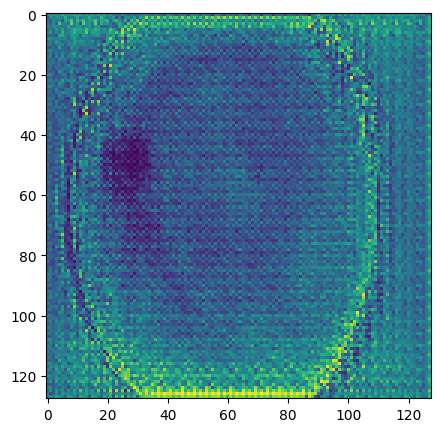

In [20]:
#plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img[1])

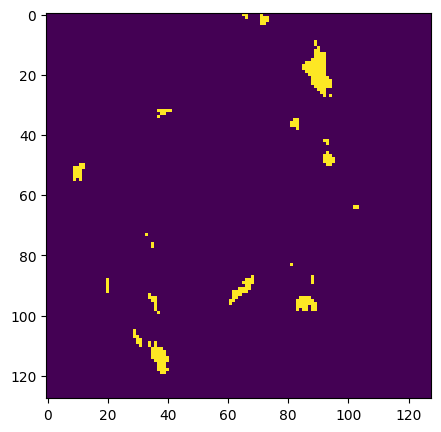

In [17]:
images = y_test.take(3)
n = []
for imgs in images:
    n.append(imgs)

plt.imshow(n[1])